In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import math

# Convert labels to one-hot vectors

# Convert classes to indicator vectors
def one_hot(values,n_values=10):
    n_v = np.maximum(n_values,np.max(values) + 1)
    oh=np.eye(n_v)[values]
    return oh

# Get Mnist data and split into train validation and test

In [3]:
def get_mnist():

    data=np.float64(np.load('/project/cmsc25025/mnist/MNIST.npy'))
    labels=np.float32(np.load('/project/cmsc25025/mnist/MNIST_labels.npy'))
    print(data.shape)
    data=np.float32(data)/255.
    train_dat=data[0:50000]
    train_labels=one_hot(np.int32(labels[0:50000]))
    val_dat=data[50000:60000]
    val_labels=one_hot(np.int32(labels[50000:60000]))
    test_dat=data[60000:70000]
    test_labels=one_hot(np.int32(labels[60000:70000]))
    
    return (train_dat, train_labels), (val_dat, val_labels), (test_dat, test_labels)

# Get CIFAR10 data and split into train validation and test

In [4]:
def get_cifar():
    tr=np.float32(np.load('/project/cmsc25025/mnist/CIFAR_10.npy'))
    tr_lb=np.int32(np.load('/project/cmsc25025/mnist/CIFAR_labels.npy'))
    tr=tr.reshape((-1,np.prod(np.array(tr.shape)[1:4])))
    train_data=tr[0:45000]/255.
    train_labels=one_hot(tr_lb[0:45000])
    val_data=tr[45000:]/255.
    val_labels=one_hot(tr_lb[45000:])
    test_data=np.float32(np.load('/project/cmsc25025/mnist/CIFAR_10_test.npy'))
    test_data=test_data.reshape((-1,np.prod(np.array(test_data.shape)[1:4])))
    test_data=test_data/255.
    test_labels=one_hot(np.int32(np.load('/project/cmsc25025/mnist/CIFAR_labels_test.npy')))
    return (train_data, train_labels), (val_data, val_labels), (test_data, test_labels)



# Get transformed Mnist data

In [5]:
def get_mnist_trans():
    test_trans_dat=np.float32(np.load('/project/cmsc25025/mnist/MNIST_TEST_TRANS.npy'))
    test_labels=one_hot(np.int32(np.float32(np.load('/project/cmsc25025/mnist/MNIST_labels.npy'))))
    return (test_trans_dat, test_labels)

# Convolution layer with relu

In [6]:
def conv_relu_layer(input,filter_size=[3,3],num_features=[1]):

    # Get number of input features from input and add to shape of new layer
    shape=filter_size+[input.get_shape().as_list()[-1],num_features]
    W = tf.get_variable('W',shape=shape) # Default initialization is Glorot (the one explained in the slides)
    b = tf.get_variable('b',shape=[num_features],initializer=tf.zeros_initializer) 
    conv = tf.nn.conv2d(input, W, strides=[1, 1, 1, 1], padding='SAME')
    relu = tf.nn.relu(conv + b)
    return(relu)

# Fully connected layer

In [7]:
def fully_connected_layer(input,num_features):
    # Make sure input is flattened.
    flat_dim=np.int32(np.array(input.get_shape().as_list())[1:].prod())
    input_flattened = tf.reshape(input, shape=[-1,flat_dim])
    shape=[flat_dim,num_features]
    W_fc = tf.get_variable('W',shape=shape) 
    b_fc = tf.get_variable('b',shape=[num_features],initializer=tf.zeros_initializer)
    fc = tf.matmul(input_flattened, W_fc) + b_fc
    return(fc)

# The network

In [8]:
#tf.reset_default_graph()

def create_network():
    pool_ksize=[1,2,2,1]
    pool_strides=[1,2,2,1]
    # The network:
    with tf.variable_scope("conv1"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu1 = conv_relu_layer(x_image, filter_size=[5, 5],num_features=32)
            pool1 = tf.nn.max_pool(relu1, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope("conv2"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu2 = conv_relu_layer(pool1, filter_size=[5, 5],num_features=64)
            pool2 = tf.nn.max_pool(relu2, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope('dropout2'):
            drop2=tf.nn.dropout(pool2,keep_prob)
    with tf.variable_scope("fc1"):
            fc1 = fully_connected_layer(drop2, num_features=256)
            fc1r=tf.nn.relu(fc1)
   
    with tf.variable_scope("fc2"):
            fc2 = fully_connected_layer(fc1r, num_features=10)

    # Names (OUT,LOSS, ACC) below added to make it easier to use this tensor when restoring model
    fc2 = tf.identity(fc2, name="OUT")
    # The loss computation
    with tf.variable_scope('cross_entropy_loss'):
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=fc2),name="LOSS")

    # Accuracy computation
    with tf.variable_scope('helpers'):
        correct_prediction = tf.equal(tf.argmax(fc2, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),name="ACC")
    # We return the final functions (they contain all the information about the graph of the network)
    return cross_entropy, accuracy, fc2

In [9]:
#tf.reset_default_graph()

def my_create_network0(nums_features = [32,64,256,10]):
    pool_ksize=[1,2,2,1]
    pool_strides=[1,2,2,1]
    # The network:
    with tf.variable_scope("conv1"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu1 = conv_relu_layer(x_image, filter_size=[5, 5],num_features=nums_features[0])
            pool1 = tf.nn.max_pool(relu1, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope("conv2"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu2 = conv_relu_layer(pool1, filter_size=[5, 5],num_features=nums_features[1])
            pool2 = tf.nn.max_pool(relu2, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope('dropout2'):
            drop2=tf.nn.dropout(pool2,keep_prob)
    with tf.variable_scope("fc1"):
            fc1 = fully_connected_layer(drop2, num_features=nums_features[2])
            fc1r=tf.nn.relu(fc1)
   
    with tf.variable_scope("fc2"):
            fc2 = fully_connected_layer(fc1r, num_features=nums_features[3])

    # Names (OUT,LOSS, ACC) below added to make it easier to use this tensor when restoring model
    fc2 = tf.identity(fc2, name="OUT")
    # The loss computation
    with tf.variable_scope('cross_entropy_loss'):
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=fc2),name="LOSS")

    # Accuracy computation
    with tf.variable_scope('helpers'):
        correct_prediction = tf.equal(tf.argmax(fc2, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),name="ACC")
    # We return the final functions (they contain all the information about the graph of the network)
    return cross_entropy, accuracy, fc2

In [10]:
#tf.reset_default_graph()

def my_create_network_deeper(nums_features = [32,64,128,128,10]):
    pool_ksize=[1,2,2,1]
    pool_strides=[1,2,2,1]
    # The network:
    with tf.variable_scope("conv1"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu1 = conv_relu_layer(x_image, filter_size=[5, 5],num_features=nums_features[0])
            pool1 = tf.nn.max_pool(relu1, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope("conv2"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu2 = conv_relu_layer(pool1, filter_size=[5, 5],num_features=nums_features[1])
            pool2 = tf.nn.max_pool(relu2, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope('dropout2'):
            drop2=tf.nn.dropout(pool2,keep_prob)
    with tf.variable_scope("fc1"):
            fc1 = fully_connected_layer(drop2, num_features=nums_features[2])
            fc1r=tf.nn.relu(fc1)
            
    with tf.variable_scope("fc2"):
            fc2 = fully_connected_layer(fc1r, num_features=nums_features[3])
            fc2r=tf.nn.relu(fc2)
   
    with tf.variable_scope("fc3"):
            fc3 = fully_connected_layer(fc2r, num_features=nums_features[4])

    # Names (OUT,LOSS, ACC) below added to make it easier to use this tensor when restoring model
    fc3 = tf.identity(fc3, name="OUT")
    # The loss computation
    with tf.variable_scope('cross_entropy_loss'):
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=fc3),name="LOSS")

    # Accuracy computation
    with tf.variable_scope('helpers'):
        correct_prediction = tf.equal(tf.argmax(fc3, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),name="ACC")
    # We return the final functions (they contain all the information about the graph of the network)
    return cross_entropy, accuracy, fc3

In [11]:
#tf.reset_default_graph()

def my_create_network_deeper2(nums_features = [32,64,224,224,224,10]):
    pool_ksize=[1,2,2,1]
    pool_strides=[1,2,2,1]
    # The network:
    with tf.variable_scope("conv1"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu1 = conv_relu_layer(x_image, filter_size=[5, 5],num_features=nums_features[0])
            pool1 = tf.nn.max_pool(relu1, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope("conv2"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu2 = conv_relu_layer(pool1, filter_size=[5, 5],num_features=nums_features[1])
            pool2 = tf.nn.max_pool(relu2, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope('dropout2'):
            drop2=tf.nn.dropout(pool2,keep_prob)
    with tf.variable_scope("fc1"):
            fc1 = fully_connected_layer(drop2, num_features=nums_features[2])
            fc1r=tf.nn.relu(fc1)
            
    with tf.variable_scope("fc2"):
            fc2 = fully_connected_layer(fc1r, num_features=nums_features[3])
            fc2r=tf.nn.relu(fc2)
    
    with tf.variable_scope("fc2_2"):
            fc2_2 = fully_connected_layer(fc2r, num_features=nums_features[3])
            fc2r_2=tf.nn.relu(fc2_2)
   
    with tf.variable_scope("fc3"):
            fc3 = fully_connected_layer(fc2r_2, num_features=nums_features[5])

    # Names (OUT,LOSS, ACC) below added to make it easier to use this tensor when restoring model
    fc3 = tf.identity(fc3, name="OUT")
    # The loss computation
    with tf.variable_scope('cross_entropy_loss'):
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=fc3),name="LOSS")

    # Accuracy computation
    with tf.variable_scope('helpers'):
        correct_prediction = tf.equal(tf.argmax(fc3, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),name="ACC")
    # We return the final functions (they contain all the information about the graph of the network)
    return cross_entropy, accuracy, fc3

In [12]:
#tf.reset_default_graph()

def my_create_network_t0(nums_features = [32,64,256,10],\
                         pool_ksize=[1,6,6,1], pool_strides=[1,2,2,1]):
    #pool_ksize=[1,2,2,1]
    pool_ksize = pool_ksize
    #pool_ksize2 = pool_ksize2
    pool_strides=pool_strides
    # The network:
    with tf.variable_scope("conv1"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu1 = conv_relu_layer(x_image, filter_size=[5, 5],num_features=nums_features[0])
            pool1 = tf.nn.max_pool(relu1, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope("conv2"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu2 = conv_relu_layer(pool1, filter_size=[5, 5],num_features=nums_features[1])
            pool2 = tf.nn.max_pool(relu2, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope('dropout2'):
            drop2=tf.nn.dropout(pool2,keep_prob)
    with tf.variable_scope("fc1"):
            fc1 = fully_connected_layer(drop2, num_features=nums_features[2])
            fc1r=tf.nn.relu(fc1)
   
    with tf.variable_scope("fc2"):
            fc2 = fully_connected_layer(fc1r, num_features=nums_features[3])

    # Names (OUT,LOSS, ACC) below added to make it easier to use this tensor when restoring model
    fc2 = tf.identity(fc2, name="OUT")
    # The loss computation
    with tf.variable_scope('cross_entropy_loss'):
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=fc2),name="LOSS")

    # Accuracy computation
    with tf.variable_scope('helpers'):
        correct_prediction = tf.equal(tf.argmax(fc2, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),name="ACC")
    # We return the final functions (they contain all the information about the graph of the network)
    return cross_entropy, accuracy, fc2

# Get loss and accuracy on a data set with output from final layer fc2

In [13]:
from scipy.special import logsumexp

def get_stats(data,labels):
    t1=time.time()
    lo=0.
    acc=0.
    delta=1000
    rr=np.arange(0,data.shape[0],delta)
    for i in rr:
        fc2_out=fc2.eval(feed_dict={x: data[i:i+delta], y_:labels[i:i+delta]})
        log_sf=logsumexp(fc2_out,axis=1).reshape((fc2_out.shape[0],1))-fc2_out
        lo+=np.mean(np.sum(labels[i:i+delta]*log_sf, axis=1))
        acc += np.mean(np.equal(np.argmax(fc2_out, axis=1),np.argmax(labels[i:i+delta], axis=1)))
    acc=acc/np.float32(len(rr))
    lo=lo/np.float32(len(rr))
    print('get stats time',time.time()-t1)
    # We return the final functions (they contain all the information about the graph of the network)
    return lo, acc

# Run one epoch

In [14]:

# Run the iterations of one epoch
def run_epoch(train,val,ii,batch_size,train_step_new):
        t1=time.time()
        # Randomly shuffle the training data
        np.random.shuffle(ii)
        tr=train[0][ii]
        y=train[1][ii]
        lo=0.
        acc=0.
        # Run disjoint batches on shuffled data
        for j in np.arange(0,len(y),batch_size):
            if (np.mod(j,5000)==0):
                print('Batch',j/batch_size)
            batch=(tr[j:j+batch_size],y[j:j+batch_size])
            train_step_new.run(feed_dict={x: batch[0], y_: batch[1], lr_: step_size,keep_prob_:keep_prob})
        print('Epoch time',time.time()-t1)

In [15]:
def get_data(data_set):
    if (data_set=="cifar"):
        return(get_cifar())
    elif (data_set=="mnist"):
        return(get_mnist())
    elif (data_set=="mnist_transform"):
        return(get_mnist_trans())

# (a)

## (i)
The number of parameters (only considering weights in the ANN) are (conv1/W + conv1/b + conv2/W + conv2/b + fc1/W +fc1/b + fc2/W + fc2/b) = 5*51*32 + 32 + 5*5*32*64 + 64 + (7*7*64)*256 + 256 + 256*10 + 10 <br>

## (ii)

In [17]:
## reference https://github.com/Hvass-Labs/TensorFlow-Tutorials

def plot_conv_layer(layer, image):
    # Assume layer is a TensorFlow op that outputs a 4-dim tensor
    # which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2.

    # Create a feed-dict containing just one image.
    # Note that we don't need to feed y_true because it is
    # not used in this calculation.
    feed_dict = {x: [image]}

    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    values = sess.run(layer, feed_dict=feed_dict)

    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

(70000, 784)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

conv1/W:0 [5, 5, 1, 32] 0.04984897
conv1/b:0 [32] 0.0
conv2/W:0 [5, 5, 32, 64] 0.028907983
conv2/b:0 [64] 0.0
fc1/W:0 [3136, 256] 0.024255468
fc1/b:0 [256] 0.0
fc2/W:0 [256, 10] 0.08639823
fc2/b:0 [10] 0.0
Batch 0.0
Batch 10.0
Epoch time 1.6918435096740723
get stats time 0.353147029876709
Epoch 0 Train loss, accuracy 0.4482795285344124 0.8669
get stats time 0.2297039031982422
EPoch 0 Validation loss, accuracy 0.45575756679773327 0.8659000000000001
Batch 0.0
Batch 10.0
Epoch time 0.674262523651123
Batch 0.0
Batch 10.0
Epoch time 0.6614406108856201
get stats time 0.22439861297607422
Epoch 2 Train loss, accuracy 0.1562100731611252 0.9526000000000001
get stats time 0.21896934509277344
EPoch 2 Validation loss, accuracy 0.1684809594154358 0.9479
Batch 0.0
Batch 10.0
Epoch time 0.65270781517

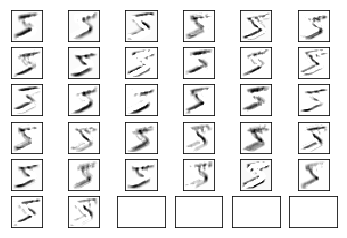

test accuracy 0.9834
Model saved in path: tmp/model


In [18]:
## run the model and plot error
import time
batch_size=500
step_size=.001
num_epochs=40
num_train=10000
minimizer="Adam"
data_set="mnist"
model_name="model"
keep_prob=.5
dim=28
nchannels=1
if (data_set=="cifar"):
    dim=32
    nchannels=3

    
## collect error
err_train = []
err_val = []

tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[None, dim*dim*nchannels],name="x")
x_image = tf.reshape(x, [-1, dim, dim, nchannels])
# Dimensions of x_image: [Batch size, Column size, Row size, Number of incoming channels]
# The number of incoming channels, for example, will be 3 if the image is color: RGB (red, green, blue)
# We will slide filter over this 2d picture with conv2d function.
y_ = tf.placeholder(tf.float32, shape=[None,10],name="y")
# Allows you to control the time step during the iterations
lr_ = tf.placeholder(tf.float32, shape=[],name="learning_rate")
keep_prob_=tf.placeholder(tf.float32, shape=[],name="keep_prob")

with tf.Session() as sess:
        train,val,test=get_data(data_set=data_set)
        # Create the network architecture with the above placeholdes as the inputs.
        cross_entropy, accuracy, fc2 =create_network()

        # Define the miminization method
        if (minimizer=="Adam"):
            train_step=tf.train.AdamOptimizer(learning_rate=lr_).minimize(cross_entropy)
        elif (minimizer=="SGD"):
            train_step = tf.train.GradientDescentOptimizer(learning_rate=lr_).minimize(cross_entropy)
        # Initialize variables
        sess.run(tf.global_variables_initializer())
        # Show trainable variables
        for v in tf.trainable_variables():
            print(v.name,v.get_shape().as_list(),np.std(v.eval()))
        ii=np.arange(0,num_train,1) #len(train_data),1)
        # Run epochs
        for i in range(num_epochs):  # number of epochs
            run_epoch(train,val,ii,batch_size,train_step)
            if (np.mod(i,2)==0):
                lo,ac = get_stats(train[0][0:num_train],train[1][0:num_train])
                
                err_train.append(1-ac)
                print('Epoch',i,'Train loss, accuracy',lo,ac)
                
                vlo,vac = get_stats(val[0],val[1])
                
                err_val.append(1-ac)
                print('EPoch',i,'Validation loss, accuracy',vlo,vac)
                # Test set accuracy
        
        ## my show images 
        image = train[0][0]
        w_out = tf.trainable_variables()[0]
        b_out = tf.trainable_variables()[1]
        conv = tf.nn.conv2d(x_image, w_out, strides=[1, 1, 1, 1], padding='SAME')
        ## conv2d : arbitrary filters that can mix channels together
        relu = tf.nn.relu(conv + b_out)
        plot_conv_layer(relu, image)
        
        
        print('test accuracy %g' % accuracy.eval(feed_dict={x: test[0], y_:test[1]}))

        # Save model
        tf.add_to_collection("optimizer", train_step)
        saver = tf.train.Saver()
        save_path = saver.save(sess, "tmp/"+model_name)
        print("Model saved in path: %s" % save_path)



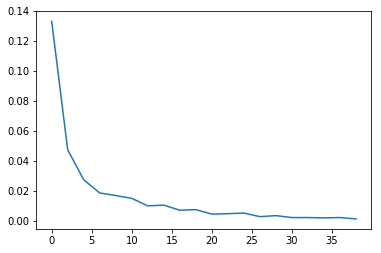

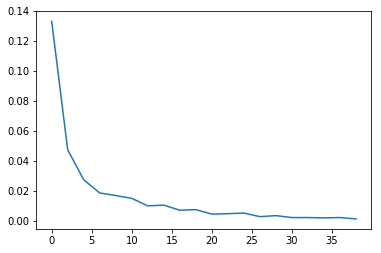

In [19]:
times = [2*i for i in range(int(0.5*num_epochs))]
plt.plot(times,err_train)
plt.show()
plt.plot(times,err_val)
plt.show()


# (b)

## (i) 
Since the number of features at different stages are [32,64,256,10], I reduce them by half or multiply them by two in the two models below (model_1_0 and model_1_1)

(70000, 784)
conv1/W:0 [5, 5, 1, 16] 0.06626024
conv1/b:0 [16] 0.0
conv2/W:0 [5, 5, 16, 32] 0.04090626
conv2/b:0 [32] 0.0
fc1/W:0 [1568, 128] 0.03430428
fc1/b:0 [128] 0.0
fc2/W:0 [128, 10] 0.11958436
fc2/b:0 [10] 0.0
Batch 0.0
Batch 10.0
Epoch time 0.6212716102600098
get stats time 0.19229507446289062
Epoch 0 Train loss, accuracy 0.7525206516742706 0.7529
get stats time 0.12084197998046875
EPoch 0 Validation loss, accuracy 0.7502213500976562 0.7497999999999999
Batch 0.0
Batch 10.0
Epoch time 0.3740236759185791
Batch 0.0
Batch 10.0
Epoch time 0.36102962493896484
get stats time 0.12416958808898926
Epoch 2 Train loss, accuracy 0.2909443348884583 0.9134999999999998
get stats time 0.1219792366027832
EPoch 2 Validation loss, accuracy 0.2998488209366798 0.9096
Batch 0.0
Batch 10.0
Epoch time 0.35977673530578613
Batch 0.0
Batch 10.0
Epoch time 0.3566727638244629
get stats time 0.1207122802734375
Epoch 4 Train loss, accuracy 0.1809331141233444 0.9472999999999999
get stats time 0.121035337448120

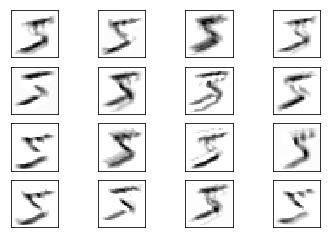

test accuracy 0.9805
Model saved in path: tmp/modelb_1_0


In [20]:
## run the model and plot error
import time
batch_size=500
step_size=.001
num_epochs=40
num_train=10000
minimizer="Adam"
data_set="mnist"
model_name="modelb_1_0"
keep_prob=.5
dim=28
nchannels=1
if (data_set=="cifar"):
    dim=32
    nchannels=3

    
## collect error
err_train = []
err_val = []

tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[None, dim*dim*nchannels],name="x")
x_image = tf.reshape(x, [-1, dim, dim, nchannels])
# Dimensions of x_image: [Batch size, Column size, Row size, Number of incoming channels]
# The number of incoming channels, for example, will be 3 if the image is color: RGB (red, green, blue)
# We will slide filter over this 2d picture with conv2d function.
y_ = tf.placeholder(tf.float32, shape=[None,10],name="y")
# Allows you to control the time step during the iterations
lr_ = tf.placeholder(tf.float32, shape=[],name="learning_rate")
keep_prob_=tf.placeholder(tf.float32, shape=[],name="keep_prob")

with tf.Session() as sess:
        train,val,test=get_data(data_set=data_set)
        # Create the network architecture with the above placeholdes as the inputs.
        cross_entropy, accuracy, fc2 =my_create_network0([16,32,128,10])

        # Define the miminization method
        if (minimizer=="Adam"):
            train_step=tf.train.AdamOptimizer(learning_rate=lr_).minimize(cross_entropy)
        elif (minimizer=="SGD"):
            train_step = tf.train.GradientDescentOptimizer(learning_rate=lr_).minimize(cross_entropy)
        # Initialize variables
        sess.run(tf.global_variables_initializer())
        # Show trainable variables
        for v in tf.trainable_variables():
            print(v.name,v.get_shape().as_list(),np.std(v.eval()))
        ii=np.arange(0,num_train,1) #len(train_data),1)
        # Run epochs
        for i in range(num_epochs):  # number of epochs
            run_epoch(train,val,ii,batch_size,train_step)
            if (np.mod(i,2)==0):
                lo,ac = get_stats(train[0][0:num_train],train[1][0:num_train])
                
                err_train.append(1-ac)
                print('Epoch',i,'Train loss, accuracy',lo,ac)
                
                vlo,vac = get_stats(val[0],val[1])
                
                err_val.append(1-ac)
                print('EPoch',i,'Validation loss, accuracy',vlo,vac)
                # Test set accuracy
        
        ## my show images 
        image = train[0][0]
        w_out = tf.trainable_variables()[0]
        b_out = tf.trainable_variables()[1]
        conv = tf.nn.conv2d(x_image, w_out, strides=[1, 1, 1, 1], padding='SAME')
        ## conv2d : arbitrary filters that can mix channels together
        relu = tf.nn.relu(conv + b_out)
        plot_conv_layer(relu, image)
        
        
        print('test accuracy %g' % accuracy.eval(feed_dict={x: test[0], y_:test[1]}))

        # Save model
        tf.add_to_collection("optimizer", train_step)
        saver = tf.train.Saver()
        save_path = saver.save(sess, "tmp/"+model_name)
        print("Model saved in path: %s" % save_path)




In [21]:
## run the model and plot error
import time
batch_size=500
step_size=.001
num_epochs=40
num_train=10000
minimizer="Adam"
data_set="mnist"
model_name="modelb_1_1"
keep_prob=.5
dim=28
nchannels=1
if (data_set=="cifar"):
    dim=32
    nchannels=3

    
## collect error
err_train = []
err_val = []

tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[None, dim*dim*nchannels],name="x")
x_image = tf.reshape(x, [-1, dim, dim, nchannels])
# Dimensions of x_image: [Batch size, Column size, Row size, Number of incoming channels]
# The number of incoming channels, for example, will be 3 if the image is color: RGB (red, green, blue)
# We will slide filter over this 2d picture with conv2d function.
y_ = tf.placeholder(tf.float32, shape=[None,10],name="y")
# Allows you to control the time step during the iterations
lr_ = tf.placeholder(tf.float32, shape=[],name="learning_rate")
keep_prob_=tf.placeholder(tf.float32, shape=[],name="keep_prob")

with tf.Session() as sess:
        train,val,test=get_data(data_set=data_set)
        # Create the network architecture with the above placeholdes as the inputs.
        cross_entropy, accuracy, fc2 =my_create_network0([64,128,512,10])

        # Define the miminization method
        if (minimizer=="Adam"):
            train_step=tf.train.AdamOptimizer(learning_rate=lr_).minimize(cross_entropy)
        elif (minimizer=="SGD"):
            train_step = tf.train.GradientDescentOptimizer(learning_rate=lr_).minimize(cross_entropy)
        # Initialize variables
        sess.run(tf.global_variables_initializer())
        # Show trainable variables
        for v in tf.trainable_variables():
            print(v.name,v.get_shape().as_list(),np.std(v.eval()))
        ii=np.arange(0,num_train,1) #len(train_data),1)
        # Run epochs
        for i in range(num_epochs):  # number of epochs
            run_epoch(train,val,ii,batch_size,train_step)
            if (np.mod(i,2)==0):
                lo,ac = get_stats(train[0][0:num_train],train[1][0:num_train])
                
                err_train.append(1-ac)
                print('Epoch',i,'Train loss, accuracy',lo,ac)
                
                vlo,vac = get_stats(val[0],val[1])
                
                err_val.append(1-ac)
                print('EPoch',i,'Validation loss, accuracy',vlo,vac)
                # Test set accuracy
        

        
        print('test accuracy %g' % accuracy.eval(feed_dict={x: test[0], y_:test[1]}))

        # Save model
        tf.add_to_collection("optimizer", train_step)
        saver = tf.train.Saver()
        save_path = saver.save(sess, "tmp/"+model_name)
        print("Model saved in path: %s" % save_path)





(70000, 784)
conv1/W:0 [5, 5, 1, 64] 0.034763683
conv1/b:0 [64] 0.0
conv2/W:0 [5, 5, 64, 128] 0.020439275
conv2/b:0 [128] 0.0
fc1/W:0 [6272, 512] 0.017165015
fc1/b:0 [512] 0.0
fc2/W:0 [512, 10] 0.061925355
fc2/b:0 [10] 0.0
Batch 0.0
Batch 10.0
Epoch time 1.9501206874847412
get stats time 0.7524991035461426
Epoch 0 Train loss, accuracy 0.3176660941243171 0.9009
get stats time 0.47524309158325195
EPoch 0 Validation loss, accuracy 0.3178613252520562 0.9004
Batch 0.0
Batch 10.0
Epoch time 1.2778542041778564
Batch 0.0
Batch 10.0
Epoch time 1.2798724174499512
get stats time 0.4716768264770508
Epoch 2 Train loss, accuracy 0.09488893461227418 0.9702
get stats time 0.47082066535949707
EPoch 2 Validation loss, accuracy 0.1067925462603569 0.9654999999999999
Batch 0.0
Batch 10.0
Epoch time 1.2794301509857178
Batch 0.0
Batch 10.0
Epoch time 1.2821762561798096
get stats time 0.475297212600708
Epoch 4 Train loss, accuracy 0.0559228479385376 0.9808999999999999
get stats time 0.47009849548339844
EPoch 

### result:
The test error rate in the reduced model (model_1_0) is 0.9783, while in the multiplied model (model_1_1) it is 0.9833. As a comparison the orginal model it is 0.9824. So the more parameters in this case improve the test accuracy a little bit. However, more parameters also means more time in each epoch. 

## (ii) 
Below I tried the following architecture: [32,64,240,210,10], [32,64,224,224,224,10], [32,64,256,224,224,10] (the first two keep the same number of parameters, while the last one has more parameters)(the numbers are the number of features in one layer)

(70000, 784)
conv1/W:0 [5, 5, 1, 32] 0.048800137
conv1/b:0 [32] 0.0
conv2/W:0 [5, 5, 32, 64] 0.02887622
conv2/b:0 [64] 0.0
fc1/W:0 [3136, 240] 0.024336992
fc1/b:0 [240] 0.0
fc2/W:0 [240, 210] 0.066787235
fc2/b:0 [210] 0.0
fc3/W:0 [210, 10] 0.094975024
fc3/b:0 [10] 0.0
Batch 0.0
Batch 10.0
Epoch time 0.8936588764190674
get stats time 0.2430107593536377
Epoch 0 Train loss, accuracy 0.43547355686426165 0.8698
get stats time 0.2194356918334961
EPoch 0 Validation loss, accuracy 0.4485174379587174 0.8694999999999998
Batch 0.0
Batch 10.0
Epoch time 0.6781699657440186
Batch 0.0
Batch 10.0
Epoch time 0.6625754833221436
get stats time 0.21741676330566406
Epoch 2 Train loss, accuracy 0.17471903624534607 0.9461999999999999
get stats time 0.2167205810546875
EPoch 2 Validation loss, accuracy 0.1832666418194771 0.9408999999999998
Batch 0.0
Batch 10.0
Epoch time 0.655937671661377
Batch 0.0
Batch 10.0
Epoch time 0.6581921577453613
get stats time 0.21680355072021484
Epoch 4 Train loss, accuracy 0.094818

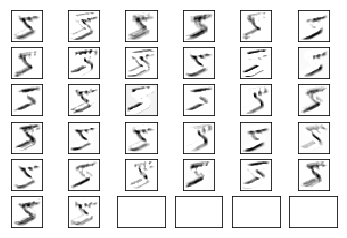

test accuracy 0.9836
Model saved in path: tmp/model_deeper_0


In [30]:
## run the model and plot error
import time
batch_size=500
step_size=.001
num_epochs=40
num_train=10000
minimizer="Adam"
data_set="mnist"
model_name="model_deeper_0"
keep_prob=.5
dim=28
nchannels=1
if (data_set=="cifar"):
    dim=32
    nchannels=3

    
## collect error
err_train = []
err_val = []

tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[None, dim*dim*nchannels],name="x")
x_image = tf.reshape(x, [-1, dim, dim, nchannels])
# Dimensions of x_image: [Batch size, Column size, Row size, Number of incoming channels]
# The number of incoming channels, for example, will be 3 if the image is color: RGB (red, green, blue)
# We will slide filter over this 2d picture with conv2d function.
y_ = tf.placeholder(tf.float32, shape=[None,10],name="y")
# Allows you to control the time step during the iterations
lr_ = tf.placeholder(tf.float32, shape=[],name="learning_rate")
keep_prob_=tf.placeholder(tf.float32, shape=[],name="keep_prob")

with tf.Session() as sess:
        train,val,test=get_data(data_set=data_set)
        # Create the network architecture with the above placeholdes as the inputs.
        cross_entropy, accuracy, fc2 =my_create_network_deeper([32,64,240,210,10])

        # Define the miminization method
        if (minimizer=="Adam"):
            train_step=tf.train.AdamOptimizer(learning_rate=lr_).minimize(cross_entropy)
        elif (minimizer=="SGD"):
            train_step = tf.train.GradientDescentOptimizer(learning_rate=lr_).minimize(cross_entropy)
        # Initialize variables
        sess.run(tf.global_variables_initializer())
        # Show trainable variables
        for v in tf.trainable_variables():
            print(v.name,v.get_shape().as_list(),np.std(v.eval()))
        ii=np.arange(0,num_train,1) #len(train_data),1)
        # Run epochs
        for i in range(num_epochs):  # number of epochs
            run_epoch(train,val,ii,batch_size,train_step)
            if (np.mod(i,2)==0):
                lo,ac = get_stats(train[0][0:num_train],train[1][0:num_train])
                
                err_train.append(1-ac)
                print('Epoch',i,'Train loss, accuracy',lo,ac)
                
                vlo,vac = get_stats(val[0],val[1])
                
                err_val.append(1-ac)
                print('EPoch',i,'Validation loss, accuracy',vlo,vac)
                # Test set accuracy
        
        ## my show images 
        image = train[0][0]
        w_out = tf.trainable_variables()[0]
        b_out = tf.trainable_variables()[1]
        conv = tf.nn.conv2d(x_image, w_out, strides=[1, 1, 1, 1], padding='SAME')
        ## conv2d : arbitrary filters that can mix channels together
        relu = tf.nn.relu(conv + b_out)
        plot_conv_layer(relu, image)
        
        
        print('test accuracy %g' % accuracy.eval(feed_dict={x: test[0], y_:test[1]}))

        # Save model
        tf.add_to_collection("optimizer", train_step)
        saver = tf.train.Saver()
        save_path = saver.save(sess, "tmp/"+model_name)
        print("Model saved in path: %s" % save_path)






In [33]:
## run the model and plot error
import time
batch_size=500
step_size=.001
num_epochs=40
num_train=10000
minimizer="Adam"
data_set="mnist"
model_name="model_deeper_1"
keep_prob=.5
dim=28
nchannels=1
if (data_set=="cifar"):
    dim=32
    nchannels=3

    
## collect error
err_train = []
err_val = []

tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[None, dim*dim*nchannels],name="x")
x_image = tf.reshape(x, [-1, dim, dim, nchannels])
# Dimensions of x_image: [Batch size, Column size, Row size, Number of incoming channels]
# The number of incoming channels, for example, will be 3 if the image is color: RGB (red, green, blue)
# We will slide filter over this 2d picture with conv2d function.
y_ = tf.placeholder(tf.float32, shape=[None,10],name="y")
# Allows you to control the time step during the iterations
lr_ = tf.placeholder(tf.float32, shape=[],name="learning_rate")
keep_prob_=tf.placeholder(tf.float32, shape=[],name="keep_prob")

with tf.Session() as sess:
        train,val,test=get_data(data_set=data_set)
        # Create the network architecture with the above placeholdes as the inputs.
        cross_entropy, accuracy, fc2 =my_create_network_deeper2([32,64,224,224,224,10])

        # Define the miminization method
        if (minimizer=="Adam"):
            train_step=tf.train.AdamOptimizer(learning_rate=lr_).minimize(cross_entropy)
        elif (minimizer=="SGD"):
            train_step = tf.train.GradientDescentOptimizer(learning_rate=lr_).minimize(cross_entropy)
        # Initialize variables
        sess.run(tf.global_variables_initializer())
        # Show trainable variables
        for v in tf.trainable_variables():
            print(v.name,v.get_shape().as_list(),np.std(v.eval()))
        ii=np.arange(0,num_train,1) #len(train_data),1)
        # Run epochs
        for i in range(num_epochs):  # number of epochs
            run_epoch(train,val,ii,batch_size,train_step)
            if (np.mod(i,2)==0):
                lo,ac = get_stats(train[0][0:num_train],train[1][0:num_train])
                
                err_train.append(1-ac)
                print('Epoch',i,'Train loss, accuracy',lo,ac)
                
                vlo,vac = get_stats(val[0],val[1])
                
                err_val.append(1-ac)
                print('EPoch',i,'Validation loss, accuracy',vlo,vac)
                # Test set accuracy
        
      
        print('test accuracy %g' % accuracy.eval(feed_dict={x: test[0], y_:test[1]}))

(70000, 784)
conv1/W:0 [5, 5, 1, 32] 0.04998337
conv1/b:0 [32] 0.0
conv2/W:0 [5, 5, 32, 64] 0.028936958
conv2/b:0 [64] 0.0
fc1/W:0 [3136, 224] 0.024404064
fc1/b:0 [224] 0.0
fc2/W:0 [224, 224] 0.06666557
fc2/b:0 [224] 0.0
fc2_2/W:0 [224, 224] 0.066686116
fc2_2/b:0 [224] 0.0
fc3/W:0 [224, 10] 0.09107214
fc3/b:0 [10] 0.0
Batch 0.0
Batch 10.0
Epoch time 0.8971526622772217
get stats time 0.2515430450439453
Epoch 0 Train loss, accuracy 0.49649948761463164 0.8471
get stats time 0.2220289707183838
EPoch 0 Validation loss, accuracy 0.5162094485163689 0.843
Batch 0.0
Batch 10.0
Epoch time 0.6812534332275391
Batch 0.0
Batch 10.0
Epoch time 0.6756200790405273
get stats time 0.21800589561462402
Epoch 2 Train loss, accuracy 0.16770881843566895 0.9517
get stats time 0.21880030632019043
EPoch 2 Validation loss, accuracy 0.1752091443181038 0.9479999999999998
Batch 0.0
Batch 10.0
Epoch time 0.6683459281921387
Batch 0.0
Batch 10.0
Epoch time 0.6671011447906494
get stats time 0.2179713249206543
Epoch 4 Tr

In [34]:
## run the model and plot error
import time
batch_size=500
step_size=.001
num_epochs=40
num_train=10000
minimizer="Adam"
data_set="mnist"
model_name="model_deeper_2"
keep_prob=.5
dim=28
nchannels=1
if (data_set=="cifar"):
    dim=32
    nchannels=3

    
## collect error
err_train = []
err_val = []

tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[None, dim*dim*nchannels],name="x")
x_image = tf.reshape(x, [-1, dim, dim, nchannels])
# Dimensions of x_image: [Batch size, Column size, Row size, Number of incoming channels]
# The number of incoming channels, for example, will be 3 if the image is color: RGB (red, green, blue)
# We will slide filter over this 2d picture with conv2d function.
y_ = tf.placeholder(tf.float32, shape=[None,10],name="y")
# Allows you to control the time step during the iterations
lr_ = tf.placeholder(tf.float32, shape=[],name="learning_rate")
keep_prob_=tf.placeholder(tf.float32, shape=[],name="keep_prob")

with tf.Session() as sess:
        train,val,test=get_data(data_set=data_set)
        # Create the network architecture with the above placeholdes as the inputs.
        cross_entropy, accuracy, fc2 =my_create_network_deeper2([32,64,256,224,224,10])

        # Define the miminization method
        if (minimizer=="Adam"):
            train_step=tf.train.AdamOptimizer(learning_rate=lr_).minimize(cross_entropy)
        elif (minimizer=="SGD"):
            train_step = tf.train.GradientDescentOptimizer(learning_rate=lr_).minimize(cross_entropy)
        # Initialize variables
        sess.run(tf.global_variables_initializer())
        # Show trainable variables
        for v in tf.trainable_variables():
            print(v.name,v.get_shape().as_list(),np.std(v.eval()))
        ii=np.arange(0,num_train,1) #len(train_data),1)
        # Run epochs
        for i in range(num_epochs):  # number of epochs
            run_epoch(train,val,ii,batch_size,train_step)
            if (np.mod(i,2)==0):
                lo,ac = get_stats(train[0][0:num_train],train[1][0:num_train])
                
                err_train.append(1-ac)
                print('Epoch',i,'Train loss, accuracy',lo,ac)
                
                vlo,vac = get_stats(val[0],val[1])
                
                err_val.append(1-ac)
                print('EPoch',i,'Validation loss, accuracy',vlo,vac)
                # Test set accuracy
        
      
        print('test accuracy %g' % accuracy.eval(feed_dict={x: test[0], y_:test[1]}))

(70000, 784)
conv1/W:0 [5, 5, 1, 32] 0.048070334
conv1/b:0 [32] 0.0
conv2/W:0 [5, 5, 32, 64] 0.028969055
conv2/b:0 [64] 0.0
fc1/W:0 [3136, 256] 0.02428934
fc1/b:0 [256] 0.0
fc2/W:0 [256, 224] 0.064581335
fc2/b:0 [224] 0.0
fc2_2/W:0 [224, 224] 0.06688118
fc2_2/b:0 [224] 0.0
fc3/W:0 [224, 10] 0.09073307
fc3/b:0 [10] 0.0
Batch 0.0
Batch 10.0
Epoch time 0.8937857151031494
get stats time 0.2483670711517334
Epoch 0 Train loss, accuracy 0.48833240683078766 0.8521000000000001
get stats time 0.2212073802947998
EPoch 0 Validation loss, accuracy 0.49485979948043834 0.8552
Batch 0.0
Batch 10.0
Epoch time 0.677483320236206
Batch 0.0
Batch 10.0
Epoch time 0.6702156066894531
get stats time 0.21885204315185547
Epoch 2 Train loss, accuracy 0.15362498872280123 0.9559
get stats time 0.2198801040649414
EPoch 2 Validation loss, accuracy 0.1611006445169449 0.9502
Batch 0.0
Batch 10.0
Epoch time 0.669180154800415
Batch 0.0
Batch 10.0
Epoch time 0.6667838096618652
get stats time 0.21953964233398438
Epoch 4 Tr

## Comment:
By simply adding one more layer with the same number of parameters, the accuracy increases from 0.98 to 0.9836. Though the increase is moderate, considering the fact that doubling the number of parameters get 0.9824 accuracy, we can see the depth of the network maybe matters more than just the number of parameters.<br>
However, as I use deeper (two more layers) network, the accuracy does not increase. I use [32,64,256,224,224,10] (increase parameters)to test if deeper network really can improves performance. The result is still almost the same. Thus, deeper network does not always improve performance. 


## (iii) 
Use the model with one layer deeper than the original one

In [19]:
train,val,test=get_data(data_set="mnist")
train[0].shape

(70000, 784)


(50000, 784)

(70000, 784)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

conv1/W:0 [5, 5, 1, 32] 0.04914404
conv1/b:0 [32] 0.0
conv2/W:0 [5, 5, 32, 64] 0.028796514
conv2/b:0 [64] 0.0
fc1/W:0 [3136, 240] 0.024364792
fc1/b:0 [240] 0.0
fc2/W:0 [240, 210] 0.06655863
fc2/b:0 [210] 0.0
fc3/W:0 [210, 10] 0.09445546
fc3/b:0 [10] 0.0
Batch 0.0
Batch 10.0
Batch 20.0
Batch 30.0
Batch 40.0
Batch 50.0
Batch 60.0
Batch 70.0
Batch 80.0
Batch 90.0
Epoch time 11.115446090698242
get stats time 1.2272121906280518
Epoch 0 Train loss, accuracy 0.1092635355734825 0.9660400000000001
get stats time 0.21979737281799316
EPoch 0 Validation loss, accuracy 0.09752671483755113 0.9682000000000001
Batch 0.0
Batch 10.0
Batch 20.0
Batch 30.0
Batch 40.0
Batch 50.0
Batch 60.0
Batch 70.0
Batch 80.0
Batch 90.0
Epoch time 3.339102029800415
Batch 0.0
Batch 10.0
Batch 20.0
Batch 30.0
Batch 40.0
B

Batch 10.0
Batch 20.0
Batch 30.0
Batch 40.0
Batch 50.0
Batch 60.0
Batch 70.0
Batch 80.0
Batch 90.0
Epoch time 3.370328903198242
Batch 0.0
Batch 10.0
Batch 20.0
Batch 30.0
Batch 40.0
Batch 50.0
Batch 60.0
Batch 70.0
Batch 80.0
Batch 90.0
Epoch time 3.3727025985717773
get stats time 1.1163678169250488
Epoch 32 Train loss, accuracy 0.007216043486595155 0.99756
get stats time 0.2142195701599121
EPoch 32 Validation loss, accuracy 0.036272793078422544 0.9905999999999999
Batch 0.0
Batch 10.0
Batch 20.0
Batch 30.0
Batch 40.0
Batch 50.0
Batch 60.0
Batch 70.0
Batch 80.0
Batch 90.0
Epoch time 3.3670434951782227
Batch 0.0
Batch 10.0
Batch 20.0
Batch 30.0
Batch 40.0
Batch 50.0
Batch 60.0
Batch 70.0
Batch 80.0
Batch 90.0
Epoch time 3.3842599391937256
get stats time 1.0789613723754883
Epoch 34 Train loss, accuracy 0.004096264123916626 0.9985800000000001
get stats time 0.2151317596435547
EPoch 34 Validation loss, accuracy 0.03246441831588745 0.9914999999999999
Batch 0.0
Batch 10.0
Batch 20.0
Batch 30.

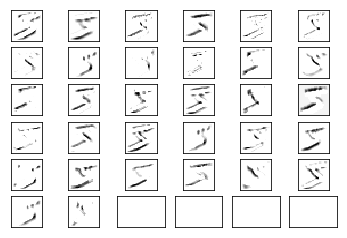

test accuracy 0.9899
Model saved in path: tmp/model_deeper_0


In [20]:
## run the model and plot error
import time
batch_size=500
step_size=.001
num_epochs=40
num_train=50000
minimizer="Adam"
data_set="mnist"
model_name="model_deeper_0"
keep_prob=.5
dim=28
nchannels=1
if (data_set=="cifar"):
    dim=32
    nchannels=3

    
## collect error
err_train = []
err_val = []

tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[None, dim*dim*nchannels],name="x")
x_image = tf.reshape(x, [-1, dim, dim, nchannels])
# Dimensions of x_image: [Batch size, Column size, Row size, Number of incoming channels]
# The number of incoming channels, for example, will be 3 if the image is color: RGB (red, green, blue)
# We will slide filter over this 2d picture with conv2d function.
y_ = tf.placeholder(tf.float32, shape=[None,10],name="y")
# Allows you to control the time step during the iterations
lr_ = tf.placeholder(tf.float32, shape=[],name="learning_rate")
keep_prob_=tf.placeholder(tf.float32, shape=[],name="keep_prob")

with tf.Session() as sess:
        train,val,test=get_data(data_set=data_set)
        # Create the network architecture with the above placeholdes as the inputs.
        cross_entropy, accuracy, fc2 =my_create_network_deeper([32,64,240,210,10])

        # Define the miminization method
        if (minimizer=="Adam"):
            train_step=tf.train.AdamOptimizer(learning_rate=lr_).minimize(cross_entropy)
        elif (minimizer=="SGD"):
            train_step = tf.train.GradientDescentOptimizer(learning_rate=lr_).minimize(cross_entropy)
        # Initialize variables
        sess.run(tf.global_variables_initializer())
        # Show trainable variables
        for v in tf.trainable_variables():
            print(v.name,v.get_shape().as_list(),np.std(v.eval()))
        ii=np.arange(0,num_train,1) #len(train_data),1)
        # Run epochs
        for i in range(num_epochs):  # number of epochs
            run_epoch(train,val,ii,batch_size,train_step)
            if (np.mod(i,2)==0):
                lo,ac = get_stats(train[0][0:num_train],train[1][0:num_train])
                
                err_train.append(1-ac)
                print('Epoch',i,'Train loss, accuracy',lo,ac)
                
                vlo,vac = get_stats(val[0],val[1])
                
                err_val.append(1-ac)
                print('EPoch',i,'Validation loss, accuracy',vlo,vac)
                # Test set accuracy
        
        ## my show images 
        image = train[0][0]
        w_out = tf.trainable_variables()[0]
        b_out = tf.trainable_variables()[1]
        conv = tf.nn.conv2d(x_image, w_out, strides=[1, 1, 1, 1], padding='SAME')
        ## conv2d : arbitrary filters that can mix channels together
        relu = tf.nn.relu(conv + b_out)
        plot_conv_layer(relu, image)
        
        
        print('test accuracy %g' % accuracy.eval(feed_dict={x: test[0], y_:test[1]}))

        # Save model
        tf.add_to_collection("optimizer", train_step)
        saver = tf.train.Saver()
        save_path = saver.save(sess, "tmp/"+model_name)
        print("Model saved in path: %s" % save_path)






## Comment
With all the data running in my best model, the accuracy is almost 0.99

# (C)

## (i) Display

In [22]:
test_t,label_t = get_data(data_set = "mnist_transform")
train,val,test = get_data(data_set = "mnist")

(70000, 784)


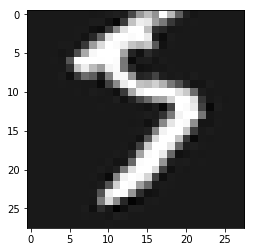

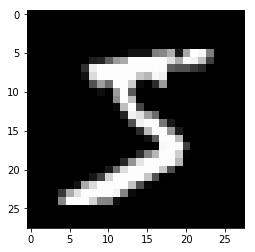

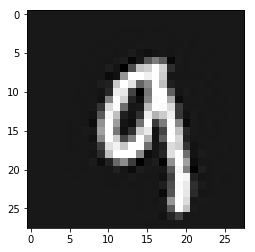

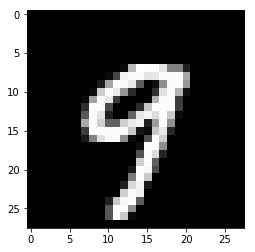

In [24]:
plt.imshow(test_t[0,:].reshape(28,28), cmap = 'gray')
plt.show()
plt.imshow(train[0][0,:].reshape(28,28), cmap = 'gray')
plt.show()
plt.imshow(test_t[45,:].reshape(28,28), cmap = 'gray')
plt.show()
plt.imshow(train[0][45,:].reshape(28,28), cmap = 'gray')
plt.show()

## (ii) try original data

In [25]:
# Run the training

import time
batch_size=500
step_size=.001
num_epochs=40
num_train=10000
minimizer="Adam"
data_set="mnist"
data_set2="mnist_transform"
model_name="model_org_t"
keep_prob=.5
dim=28
nchannels=1
if (data_set=="cifar"):
    dim=32
    nchannels=3


tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[None, dim*dim*nchannels],name="x")
x_image = tf.reshape(x, [-1, dim, dim, nchannels])
# Dimensions of x_image: [Batch size, Column size, Row size, Number of incoming channels]
# The number of incoming channels, for example, will be 3 if the image is color: RGB (red, green, blue)
# We will slide filter over this 2d picture with conv2d function.
y_ = tf.placeholder(tf.float32, shape=[None,10],name="y")
# Allows you to control the time step during the iterations
lr_ = tf.placeholder(tf.float32, shape=[],name="learning_rate")
keep_prob_=tf.placeholder(tf.float32, shape=[],name="keep_prob")

with tf.Session() as sess:
        train=get_data(data_set=data_set)[0]
        
        data_t,label_t=get_data(data_set=data_set2)
        #train = (data_t[:50000,:],label_t[:50000,:])
        val = (data_t[50000:60000,:],label_t[50000:60000,:])
        test = (data_t[60000:,:],label_t[60000:,:])
        
        # Create the network architecture with the above placeholdes as the inputs.
        cross_entropy, accuracy, fc2 =create_network()

        # Define the miminization method
        if (minimizer=="Adam"):
            train_step=tf.train.AdamOptimizer(learning_rate=lr_).minimize(cross_entropy)
        elif (minimizer=="SGD"):
            train_step = tf.train.GradientDescentOptimizer(learning_rate=lr_).minimize(cross_entropy)
        # Initialize variables
        sess.run(tf.global_variables_initializer())
        # Show trainable variables
        for v in tf.trainable_variables():
            print(v.name,v.get_shape().as_list(),np.std(v.eval()))
        ii=np.arange(0,num_train,1) #len(train_data),1)
        # Run epochs
        for i in range(num_epochs):  # number of epochs
            run_epoch(train,val,ii,batch_size,train_step)
            if (np.mod(i,2)==0):
                lo,ac = get_stats(train[0][0:num_train],train[1][0:num_train])
                print('Epoch',i,'Train loss, accuracy',lo,ac)
                vlo,vac = get_stats(val[0],val[1])
                print('EPoch',i,'Validation loss, accuracy',vlo,vac)
                # Test set accuracy

        print('test accuracy %g' % accuracy.eval(feed_dict={x: test[0], y_:test[1]}))

        # Save model
        tf.add_to_collection("optimizer", train_step)
        saver = tf.train.Saver()
        save_path = saver.save(sess, "tmp/"+model_name)
        print("Model saved in path: %s" % save_path)



(70000, 784)
conv1/W:0 [5, 5, 1, 32] 0.049018368
conv1/b:0 [32] 0.0
conv2/W:0 [5, 5, 32, 64] 0.02884209
conv2/b:0 [64] 0.0
fc1/W:0 [3136, 256] 0.02427195
fc1/b:0 [256] 0.0
fc2/W:0 [256, 10] 0.08708927
fc2/b:0 [10] 0.0
Batch 0.0
Batch 10.0
Epoch time 0.8851244449615479
get stats time 0.25666165351867676
Epoch 0 Train loss, accuracy 0.4225864974737168 0.8718
get stats time 0.22640061378479004
EPoch 0 Validation loss, accuracy 3.132067643332481 0.3394
Batch 0.0
Batch 10.0
Epoch time 0.6786906719207764
Batch 0.0
Batch 10.0
Epoch time 0.6763641834259033
get stats time 0.22584247589111328
Epoch 2 Train loss, accuracy 0.14590953574180604 0.9578999999999999
get stats time 0.21957921981811523
EPoch 2 Validation loss, accuracy 2.375671470534802 0.4378
Batch 0.0
Batch 10.0
Epoch time 0.6608531475067139
Batch 0.0
Batch 10.0
Epoch time 0.6600513458251953
get stats time 0.22120046615600586
Epoch 4 Train loss, accuracy 0.08874740862846375 0.9743999999999999
get stats time 0.2188727855682373
EPoch 4 V

### analysis of experiment of using orginal model and testing on transformed data
From the experiment we can see that the accuracy drops drammatically, to around 58%. 

### (iii) propose changes to the original model
I change the pooling ksize and stride. I performed many experiments and list the results at the end. I only show the computation for the best model below (with ksize [1,9,9,1] and stride [1,3,3,1])

In [26]:
# Run the training

import time
batch_size=500
step_size=.001
num_epochs=40
num_train=10000
minimizer="Adam"
data_set="mnist"
data_set2="mnist_transform"
model_name="model_new_t_size9_stride3"
keep_prob=.5
dim=28
nchannels=1
if (data_set=="cifar"):
    dim=32
    nchannels=3


tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[None, dim*dim*nchannels],name="x")
x_image = tf.reshape(x, [-1, dim, dim, nchannels])
# Dimensions of x_image: [Batch size, Column size, Row size, Number of incoming channels]
# The number of incoming channels, for example, will be 3 if the image is color: RGB (red, green, blue)
# We will slide filter over this 2d picture with conv2d function.
y_ = tf.placeholder(tf.float32, shape=[None,10],name="y")
# Allows you to control the time step during the iterations
lr_ = tf.placeholder(tf.float32, shape=[],name="learning_rate")
keep_prob_=tf.placeholder(tf.float32, shape=[],name="keep_prob")

with tf.Session() as sess:
        train=get_data(data_set=data_set)[0]
        
        data_t,label_t=get_data(data_set=data_set2)
        #train = (data_t[:50000,:],label_t[:50000,:])
        val = (data_t[50000:60000,:],label_t[50000:60000,:])
        test = (data_t[60000:,:],label_t[60000:,:])
        
        # Create the network architecture with the above placeholdes as the inputs.
        cross_entropy, accuracy, fc2 =my_create_network_t0(pool_ksize=[1,9,9,1],\
                                                           pool_strides=[1,3,3,1])

        # Define the miminization method
        if (minimizer=="Adam"):
            train_step=tf.train.AdamOptimizer(learning_rate=lr_).minimize(cross_entropy)
        elif (minimizer=="SGD"):
            train_step = tf.train.GradientDescentOptimizer(learning_rate=lr_).minimize(cross_entropy)
        # Initialize variables
        sess.run(tf.global_variables_initializer())
        # Show trainable variables
        for v in tf.trainable_variables():
            print(v.name,v.get_shape().as_list(),np.std(v.eval()))
        ii=np.arange(0,num_train,1) #len(train_data),1)
        # Run epochs
        for i in range(num_epochs):  # number of epochs
            run_epoch(train,val,ii,batch_size,train_step)
            if (np.mod(i,2)==0):
                lo,ac = get_stats(train[0][0:num_train],train[1][0:num_train])
                print('Epoch',i,'Train loss, accuracy',lo,ac)
                vlo,vac = get_stats(val[0],val[1])
                print('EPoch',i,'Validation loss, accuracy',vlo,vac)
                # Test set accuracy

        print('test accuracy %g' % accuracy.eval(feed_dict={x: test[0], y_:test[1]}))

        # Save model
        tf.add_to_collection("optimizer", train_step)
        saver = tf.train.Saver()
        save_path = saver.save(sess, "tmp/"+model_name)
        print("Model saved in path: %s" % save_path)









(70000, 784)
conv1/W:0 [5, 5, 1, 32] 0.0485146
conv1/b:0 [32] 0.0
conv2/W:0 [5, 5, 32, 64] 0.028784038
conv2/b:0 [64] 0.0
fc1/W:0 [1024, 256] 0.039508898
fc1/b:0 [256] 0.0
fc2/W:0 [256, 10] 0.08771751
fc2/b:0 [10] 0.0
Batch 0.0
Batch 10.0
Epoch time 0.9228222370147705
get stats time 0.23228049278259277
Epoch 0 Train loss, accuracy 1.1338774825811386 0.655
get stats time 0.1754913330078125
EPoch 0 Validation loss, accuracy 1.9231937439203264 0.3456
Batch 0.0
Batch 10.0
Epoch time 0.5957107543945312
Batch 0.0
Batch 10.0
Epoch time 0.5920295715332031
get stats time 0.17769742012023926
Epoch 2 Train loss, accuracy 0.237403590285778 0.9327000000000002
get stats time 0.17354130744934082
EPoch 2 Validation loss, accuracy 1.8248793835282324 0.5164
Batch 0.0
Batch 10.0
Epoch time 0.5921800136566162
Batch 0.0
Batch 10.0
Epoch time 0.5894832611083984
get stats time 0.1723771095275879
Epoch 4 Train loss, accuracy 0.14670280714035033 0.9571
get stats time 0.17130208015441895
EPoch 4 Validation loss

### Analysis on different experiments with different pool_ksize and pool_stride

pool_ksize     pool_stride     acc <br> 
2 2 0.58 <br>
4 2 0.683 <br>
6 2 0.69 <br>
... <br>
9 2 0.7149 <br>
10 2 0.7204 <br>
11 2 0.7183 <br>
... <br>
14 2 0.7102 <br>
From above we can see the best results for fixed stride of 2 is 0.7204, achieved with ksize of 10. Below try fixed stride of 3: <br> 

6 3 0.7115 <br>
7 3 0.7137 <br>
8 3 0.715 <br>
9 3 0.728 <br>
10 3 0.7197 <br>
From above we can see the best results for fixed stride of 3 is 0.7274, achieved with ksize of 9. Below try fixed stride of 4: <br>


6 4 0.6901 <br>
8 4 0.7035 <br>
9 4 0.7183 <br>
10 4 0.6924 <br>
... <br>
12 4 0.6942 <br>


From above we can see the best results for fixed stride of 7 is 0.7183, achieved with ksize of 9.  <br>

To Conclude, to achieve better accuracy on transformed data sets, it is better to choose a larger pool window (9 or 10, bigger than that might loose too much nontrivial information). And from experiments the best way is to set ksize as 9 and stride as 3. The best accuracy is 0.728